In [27]:
import sys
from enum import Enum

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LassoCV, ElasticNetCV, LogisticRegression

import data_processing as dp
import ml_tools as mlt
import dashboard as db
import data_visualization as dv

# Variable Declaration
df = None
features_selected = list()


class Level:
    judge, panel, circuityear = range(3)

# Run Parameters
run_level = Level.circuityear
run_lasso = False  # chooses handpicked variables if False or lasso chooses the features
run_random_forest = True
run_elastic_net = False
run_logistic_regression = False


def _filter_data_():
    sys.stdout.write(("\nFiltering data for legal area: " + db.legal_area).ljust(50))
    # dp.read_and_process_vote_level_data()
    sys.stdout.write("--complete\n")


def _handpick_features_from_filtered_data_():
    sys.stdout.write("\nHandpicking imp features from filtered data".ljust(50))
    df = dp.read_filtered_data_into_dataframe()
    dp.handpick_features_from_char_data(df)
    sys.stdout.write("--complete\n")


def _merge_instruments_z_x_():
    sys.stdout.write("\nMerging Data to produce Instruments Z-X".ljust(50))
    df = dp.read_handpicked_features_data_into_dataframe()
    dp.merge_char_with_legal_data(df)
    sys.stdout.write("--complete\n")


def _generate_level_files_():
    df = dp.read_char_with_legal_data()
    sys.stdout.write("\nAggregating Data".ljust(50))
    sys.stdout.write("\nJudge Level".ljust(50))
    dp.aggregate_on_judge_level(df)
    sys.stdout.write("--complete" + ' ')
    if run_level != Level.judge:
        sys.stdout.write("\nPanel Level".ljust(50))
        dp.aggregate_on_panel_level()
        sys.stdout.write("--complete" + ' ')
    if run_level == Level.circuityear:
        sys.stdout.write("\nCircuit Year Level".ljust(50))
        dp.aggregate_on_circuityear_level()
        sys.stdout.write("--complete\n")


def _generate_expectations_at_circuityear_level_():
    sys.stdout.write("\nGenerating Expectations".ljust(50))
    # dp.generate_expectations()
    sys.stdout.write("--complete\n")



def _read_data_():
    global df
    sys.stdout.write("\nReading & Loading Data".ljust(50))
    dp.read_and_process_vote_level_data()
    # dp.read_vote_level_data_into_dataframe()
    # df = dp.read_filtered_data_into_dataframe()
    df = dp.read_judge_level_data()
    sys.stdout.write("--complete\n")


def _clean_data_(df):
    sys.stdout.write("\nCleaning Data".ljust(50))
    df = dp.clean_nan_values(df)
    df = dp.clean_na_values(df)
    sys.stdout.write("--complete\n")
    return df


def _run_regression_():
    global features_selected
    models = {}
    sys.stdout.write("\nRunning Regression".ljust(50))
    df = dp.read_circuityear_level_data()
    train, test = dp.split_into_train_and_test(df)
    # mlt.ols_sklearn(train, test)
    features_selected = db.ols_filter_col
    if run_lasso:
        features_selected = mlt.feature_selection(df, LassoCV())
    elif run_random_forest:
        features_selected = mlt.feature_selection(df, ExtraTreesClassifier())
    elif run_elastic_net:
        features_selected = mlt.feature_selection(df, ElasticNetCV())
    elif run_logistic_regression:
        features_selected = mlt.feature_selection(df, LogisticRegression())
    i = 1
    models[0] = mlt.fit_stat_model(df, features_selected)
    if Level.panel or Level.circuityear:
        df = dp.read_panel_level_data()
        _clean_data_(df)
        models[i] = mlt.fit_stat_model(df, features_selected)
        i += 1
    if Level.circuityear:
        df = dp.read_circuityear_level_data()
        _clean_data_(df)
        models[i] = mlt.fit_stat_model(df, features_selected)
    mlt.compare_and_print_statsmodels(models)
    sys.stdout.write("--complete\n")


def _run_regression_for_lags_leads_():
    global features_selected
    df = dp.read_lags_leads_data()
    models = {}
    i = 1
    models[0] = mlt.fit_stat_model(df, features_selected)

    lag_features = list()
    for itr in range(db.num_lags):
        for feature in features_selected:
            lag_features.append(feature + '_t' + str(itr + 1))
        df_clean = df.dropna(subset=lag_features)
        models[i] = mlt.fit_stat_model(df_clean, lag_features)
        i += 1
        lag_features = list()

    lead_features = list()
    for itr in range(db.num_leads):
        for feature in features_selected:
            lead_features.append(feature + '_f' + str(itr + 1))
        df_clean = df.dropna(subset=lead_features)
        models[i] = mlt.fit_stat_model(df_clean, lead_features)
        i += 1
        lead_features = list()

    mlt.compare_and_print_statsmodels(models)


def _generate_lags_leads_():
    global features_selected
    dp.generate_lags_and_leads(features_selected, db.num_lags, db.num_leads)


def _generate_plots_():
    sys.stdout.write("\nGenerating Plots".ljust(50))
    df = dp.read_circuityear_level_data()
    df2 = dp.read_expectations_data()
    dv.all_circuit_comparison(expected=df2, actual=df)
    sys.stdout.write("--complete\n")

In [28]:
_filter_data_()


Filtering data for legal area: evironment        --complete


In [29]:
_handpick_features_from_filtered_data_()


Handpicking imp features from filtered data      --complete


In [30]:
_merge_instruments_z_x_()


Merging Data to produce Instruments Z-X          --complete


In [31]:
_generate_level_files_()


Aggregating Data                                 
Judge Level                                      --complete 
Panel Level                                      --complete 
Circuit Year Level                               --complete


In [32]:
_generate_expectations_at_circuityear_level_()


Generating Expectations                          --complete


In [33]:
_run_regression_()


Running Regression                               

KeyError: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [36]:
_generate_lags_leads_()


Generating Plots                                 Something


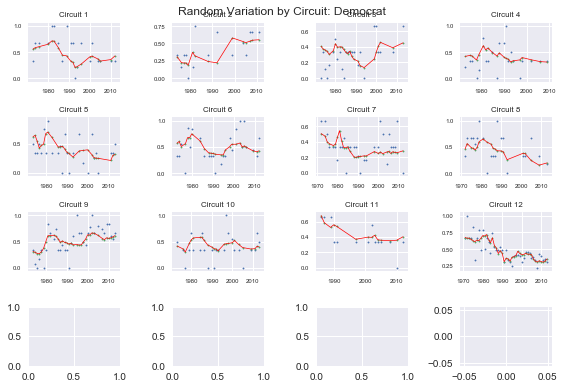

--complete


In [35]:
_generate_plots_() 